# 신경망 모델

- 케라스 사용
- 시계열 예측 모델 (t+1)
- GEFCom2014 경진대회 데이터 사용 (2012~2014) 전력사용 및 기온 데이터
- AR 모델 (자신의 과거 데이터만 사용)

In [1]:
import os
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
from glob import glob
from collections import UserDict
from common.utils import load_data, mape
from IPython.display import Image
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

pd.options.display.float_format = '{:,.2f}'.format
np.set_printoptions(precision=2)
warnings.filterwarnings("ignore")

In [19]:
# energy = load_data('data')[['load']]
energy = pd.read_csv(os.path.join('data', 'energy.csv'), parse_dates=['timestamp']) 

In [20]:
energy[:3]

,timestamp,load,temp
0,2012-01-01 00:00:00,"2,698.00",32.00
1,2012-01-01 01:00:00,"2,558.00",32.67
2,2012-01-01 02:00:00,"2,444.00",30.00


In [21]:
# 인덱스를 변경하고 전체 샘플수를 확인한다.
energy.index = energy['timestamp']
energy = energy.reindex(pd.date_range(min(energy['timestamp']),
                max(energy['timestamp']), freq='H'))
energy = energy.drop('timestamp', axis=1)[['load']]
energy.head()

,load
2012-01-01 00:00:00,"2,698.00"
2012-01-01 01:00:00,"2,558.00"
2012-01-01 02:00:00,"2,444.00"
2012-01-01 03:00:00,"2,402.00"
2012-01-01 04:00:00,"2,403.00"


## 훈련, 검증, 테스트 데이터

- 시계열 분석에서는 뒷 시간의 데이터를 훈련에 사용하지 않도록 해야 한다. 미래를 예측하는 것이므로
- 아래의 시점을 기준으로 훈련, 검증, 테스트 데이터를 나눈다 (시작은 2012.1.1)

In [22]:
valid_start_dt = '2014-09-01 00:00:00'
test_start_dt = '2014-11-01 00:00:00'

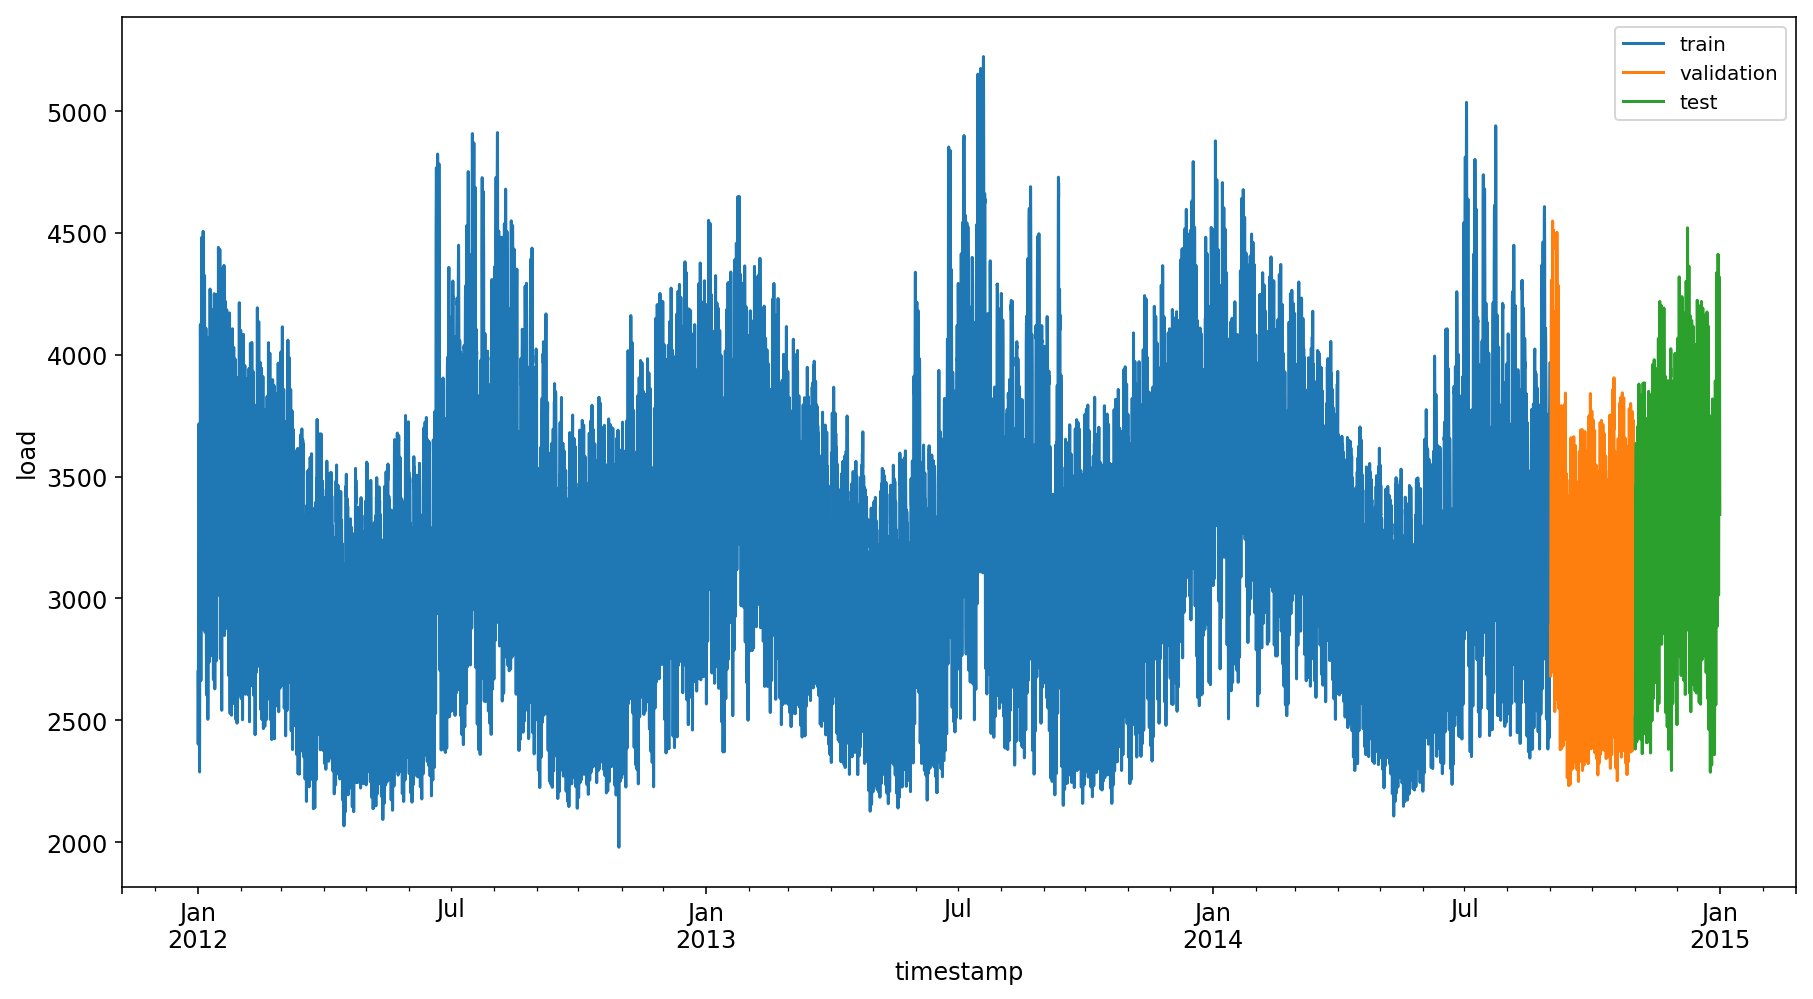

In [107]:
energy[energy.index < valid_start_dt][['load']].rename(columns={'load':'train'}) \
    .join(energy[(energy.index >=valid_start_dt) & (energy.index < test_start_dt)][['load']] \
          .rename(columns={'load':'validation'}), how='outer') \
    .join(energy[test_start_dt:][['load']].rename(columns={'load':'test'}), how='outer') \
    .plot(y=['train', 'validation', 'test'], figsize=(15, 8), fontsize=12)
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('load', fontsize=12)
plt.show()

## 훈련 데이터

- 여기서는 6개의 샘플을 묶어서 하나의 입력으로 사용하겠다(임의로 정한 값임). (T=6)
- 예측 값은 1로 정한다. 미래 한 시간 후를 예측 (HORIZON=1)

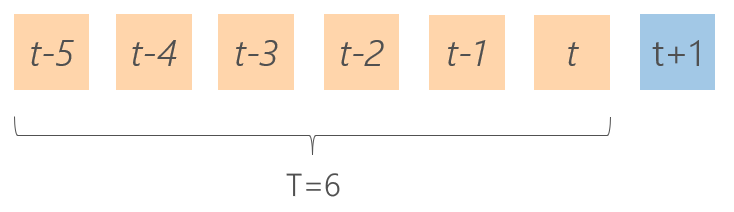

In [108]:
Image('./images/one_step_forecast.png')

In [109]:
T = 6
HORIZON = 1

### 데이터 준비

- 최소최대 스케일링
- 데이터 프레임 생성
- 결측치는 버린다
- ndarray 생성

### 1. 훈련 데이터

In [110]:
train = energy.copy()[energy.index < valid_start_dt][['load']]
train.shape

(23376, 1)

### 2. 스케일링 (훈련 데이터만 수행)

In [111]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(train)
train['load'] = scaler.transform(train)
train.head()

,load
2012-01-01 00:00:00,0.22
2012-01-01 01:00:00,0.18
2012-01-01 02:00:00,0.14
2012-01-01 03:00:00,0.13
2012-01-01 04:00:00,0.13


스케일링 확인

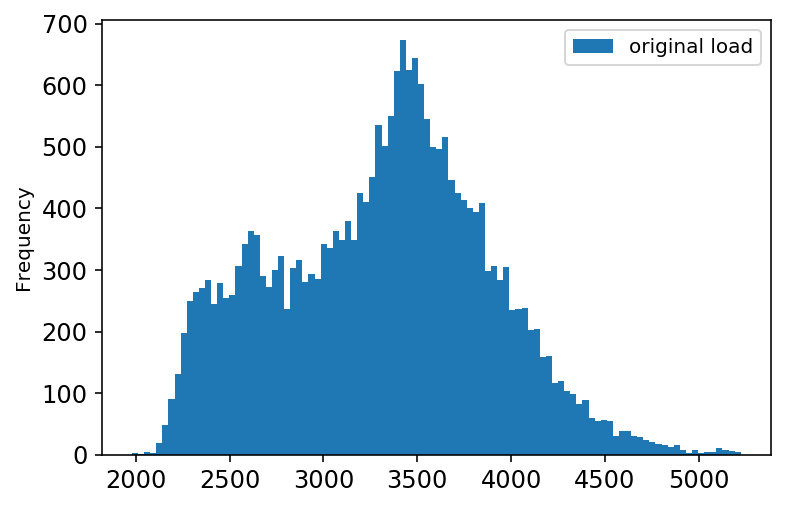

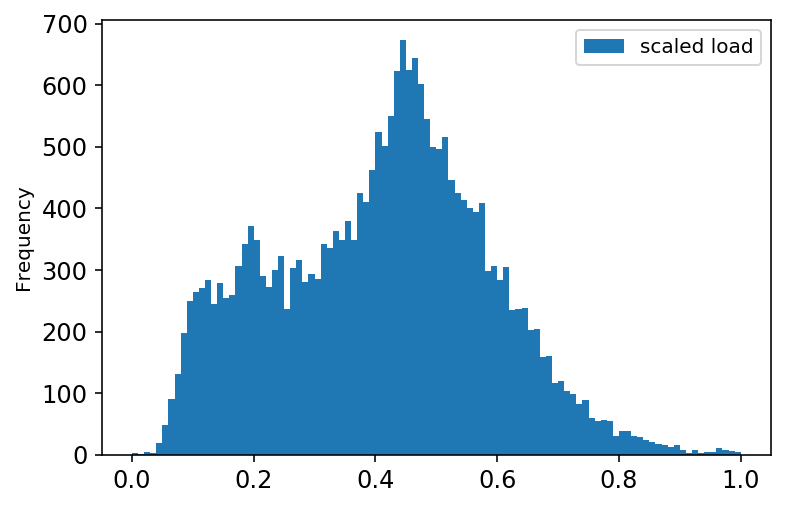

In [112]:
energy[energy.index < valid_start_dt][['load']].rename(columns={'load':'original load'}).plot.hist(bins=100, fontsize=12)
train.rename(columns={'load':'scaled load'}).plot.hist(bins=100, fontsize=12)
plt.show()

### 3. 예측할 미래 값을 컬럼으로 생섣

In [113]:
train_shifted = train.copy()
train_shifted['y_t+1'] = train_shifted['load'].shift(-1, freq='H')
train_shifted.head(10)

,load,y_t+1
2012-01-01 00:00:00,0.22,0.18
2012-01-01 01:00:00,0.18,0.14
2012-01-01 02:00:00,0.14,0.13
2012-01-01 03:00:00,0.13,0.13
2012-01-01 04:00:00,0.13,0.15
2012-01-01 05:00:00,0.15,0.18
2012-01-01 06:00:00,0.18,0.23
2012-01-01 07:00:00,0.23,0.29
2012-01-01 08:00:00,0.29,0.35
2012-01-01 09:00:00,0.35,0.37


과거 T(6)개 샘플을 모두 표현하는 컬럼을 만든다.

In [114]:
for t in range(1, T+1):
    train_shifted[str(T-t)] = train_shifted['load'].shift(T-t, freq='H')

In [115]:
train_shifted[:3]

,load,y_t+1,5,4,3,2,1,0
2012-01-01 00:00:00,0.22,0.18,nan,nan,nan,nan,nan,0.22
2012-01-01 01:00:00,0.18,0.14,nan,nan,nan,nan,0.22,0.18
2012-01-01 02:00:00,0.14,0.13,nan,nan,nan,0.22,0.18,0.14


In [116]:
y_col = 'y_t+1'
X_cols = ['load_t-5',
          'load_t-4',
          'load_t-3',
          'load_t-2',
          'load_t-1',
          'load_t']
train_shifted.columns = ['load_original']+[y_col]+X_cols
train_shifted.head(10)

,load_original,y_t+1,load_t-5,load_t-4,load_t-3,load_t-2,load_t-1,load_t
2012-01-01 00:00:00,0.22,0.18,nan,nan,nan,nan,nan,0.22
2012-01-01 01:00:00,0.18,0.14,nan,nan,nan,nan,0.22,0.18
2012-01-01 02:00:00,0.14,0.13,nan,nan,nan,0.22,0.18,0.14
2012-01-01 03:00:00,0.13,0.13,nan,nan,0.22,0.18,0.14,0.13
2012-01-01 04:00:00,0.13,0.15,nan,0.22,0.18,0.14,0.13,0.13
2012-01-01 05:00:00,0.15,0.18,0.22,0.18,0.14,0.13,0.13,0.15
2012-01-01 06:00:00,0.18,0.23,0.18,0.14,0.13,0.13,0.15,0.18
2012-01-01 07:00:00,0.23,0.29,0.14,0.13,0.13,0.15,0.18,0.23
2012-01-01 08:00:00,0.29,0.35,0.13,0.13,0.15,0.18,0.23,0.29
2012-01-01 09:00:00,0.35,0.37,0.13,0.15,0.18,0.23,0.29,0.35


### 4. 모든 결측치는 버린다

In [117]:
train_shifted = train_shifted.dropna(how='any')
train_shifted.head(5)

,load_original,y_t+1,load_t-5,load_t-4,load_t-3,load_t-2,load_t-1,load_t
2012-01-01 05:00:00,0.15,0.18,0.22,0.18,0.14,0.13,0.13,0.15
2012-01-01 06:00:00,0.18,0.23,0.18,0.14,0.13,0.13,0.15,0.18
2012-01-01 07:00:00,0.23,0.29,0.14,0.13,0.13,0.15,0.18,0.23
2012-01-01 08:00:00,0.29,0.35,0.13,0.13,0.15,0.18,0.23,0.29
2012-01-01 09:00:00,0.35,0.37,0.13,0.15,0.18,0.23,0.29,0.35


### 5. dnarray로 변환

In [118]:
y_train = train_shifted[[y_col]].as_matrix()
X_train = train_shifted[X_cols].as_matrix()

In [119]:
y_train.shape

(23370, 1)

The target varaible for the first 3 samples looks like:

In [120]:
y_train[:3]

array([[0.18],
       [0.23],
       [0.29]])

The tensor for the input features now has the shape:

In [121]:
X_train.shape

(23370, 6)

And the first 3 samples looks like:

In [122]:
X_train[:3]

array([[0.22, 0.18, 0.14, 0.13, 0.13, 0.15],
       [0.18, 0.14, 0.13, 0.13, 0.15, 0.18],
       [0.14, 0.13, 0.13, 0.15, 0.18, 0.23]])

## 검증데이터 (6시간 이전의 샘플부터 필요하다)

In [123]:
look_back_dt = dt.datetime.strptime(valid_start_dt, '%Y-%m-%d %H:%M:%S') - dt.timedelta(hours=T-1)
valid = energy.copy()[(energy.index >=look_back_dt) & (energy.index < test_start_dt)][['load']]
valid.head()

,load
2014-08-31 19:00:00,"3,969.00"
2014-08-31 20:00:00,"3,869.00"
2014-08-31 21:00:00,"3,643.00"
2014-08-31 22:00:00,"3,365.00"
2014-08-31 23:00:00,"3,097.00"


- 스케일링 (훈련데이터에서 구한 fit 결과를 사용한다)

In [124]:
valid['load'] = scaler.transform(valid)
valid.head()

,load
2014-08-31 19:00:00,0.61
2014-08-31 20:00:00,0.58
2014-08-31 21:00:00,0.51
2014-08-31 22:00:00,0.43
2014-08-31 23:00:00,0.34


검증 데이터 준비

In [125]:
valid_shifted = valid.copy()
valid_shifted['y+1'] = valid_shifted['load'].shift(-1, freq='H')
for t in range(1, T+1):
    valid_shifted['load_t-'+str(T-t)] = valid_shifted['load'].shift(T-t, freq='H')
valid_shifted = valid_shifted.dropna(how='any')
y_valid = valid_shifted['y+1'].as_matrix()
X_valid = valid_shifted[['load_t-'+str(T-t) for t in range(1, T+1)]].as_matrix()

In [126]:
y_valid.shape

(1463,)

In [127]:
X_valid.shape

(1463, 6)

## 신경망

입력이 6개 히든 계층의 뉴런이 5개, 출력이 하나인 신경망을 만들었다.

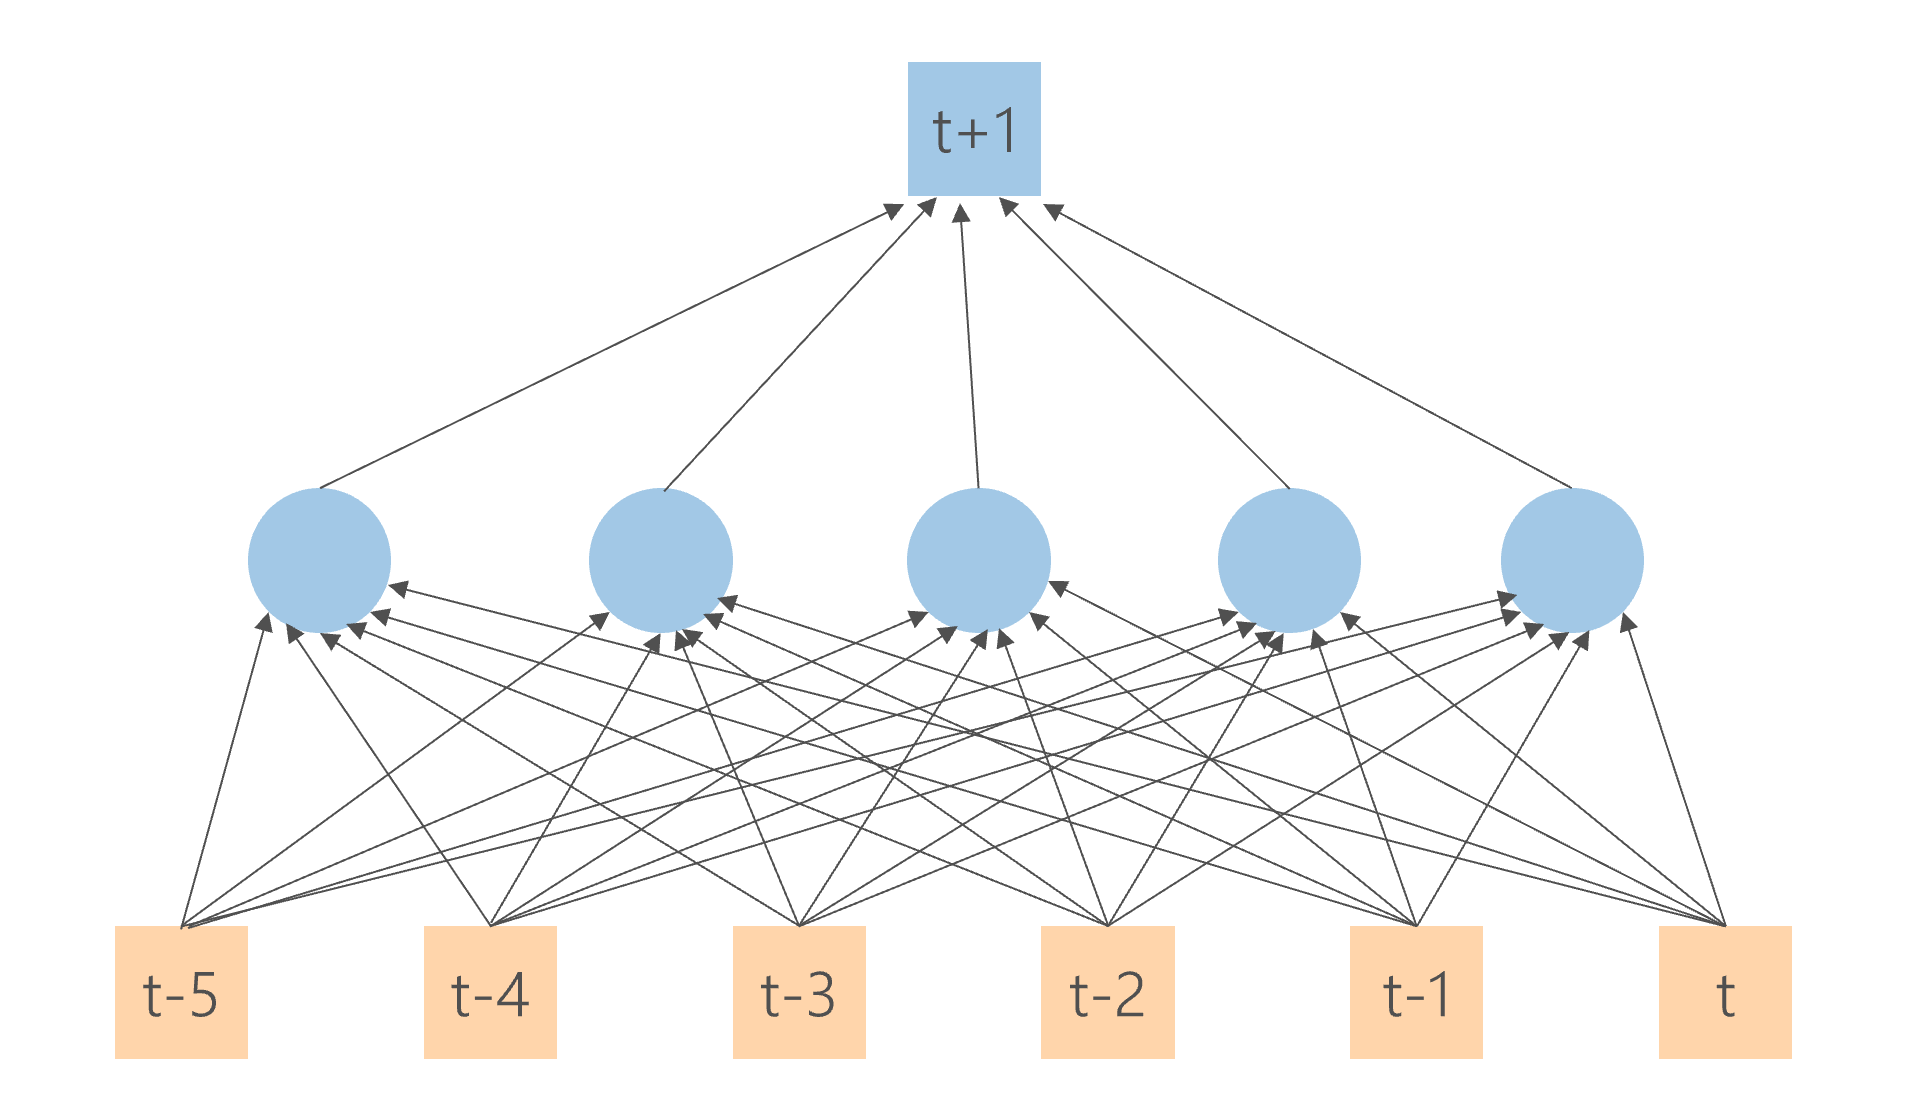

In [128]:
Image('./images/ff_one_step_univariate.png')

In [129]:
from keras import regularizers
from keras.models import Model, Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [130]:
LATENT_DIM = 5 # number of units in the dense layer
BATCH_SIZE = 32 # number of samples per mini-batch
EPOCHS = 50 # maximum number of times the training algorithm will cycle through all samples

model = Sequential()
model.add(Dense(LATENT_DIM, activation="relu", input_shape=(T,)))
model.add(Dense(HORIZON))
model.compile(optimizer='RMSprop', loss='mse')
model.summary()

Specify the early stopping criteria. We **monitor** the validation loss (in this case the mean squared error) on the validation set after each training epoch. If the validation loss has not improved by **min_delta** after **patience** epochs, we stop the training.

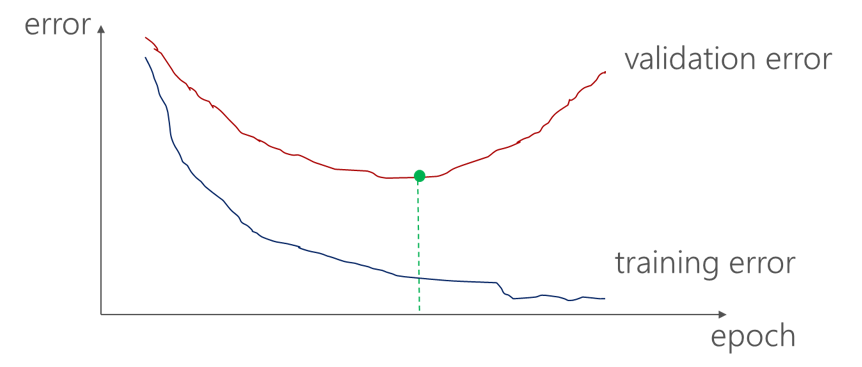

In [133]:
Image('./images/early_stopping.png')

In [100]:
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5)
best_val = ModelCheckpoint('model_{epoch:02d}.h5', save_best_only=True, 
                           mode='min', period=1)
history = model.fit(X_train,
                    y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(X_valid, y_valid),
                    callbacks=[earlystop, best_val],
                    verbose=1)

Train on 23370 samples, validate on 1463 samples
Epoch 1/50
23370/23370 [==============================] - 1s 41us/step - loss: 0.0670 - val_loss: 0.0046
Epoch 2/50
23370/23370 [==============================] - 1s 31us/step - loss: 0.0039 - val_loss: 0.0025
Epoch 3/50
23370/23370 [==============================] - 1s 31us/step - loss: 0.0023 - val_loss: 0.0020
Epoch 4/50
23370/23370 [==============================] - 1s 32us/step - loss: 0.0016 - val_loss: 0.0013
Epoch 5/50
23370/23370 [==============================] - 1s 33us/step - loss: 0.0013 - val_loss: 0.0011
Epoch 6/50
23370/23370 [==============================] - 1s 38us/step - loss: 0.0011 - val_loss: 0.0014
Epoch 7/50
23370/23370 [==============================] - 1s 47us/step - loss: 0.0011 - val_loss: 0.0011
Epoch 8/50
23370/23370 [==============================] - 1s 42us/step - loss: 9.8697e-04 - val_loss: 9.3630e-04
Epoch 9/50
23370/23370 [==============================] - 1s 39us/step - loss: 9.3062e-04 - val_loss: 8

In [134]:
best_epoch = np.argmin(np.array(history.history['val_loss']))+1
model.load_weights("model_{:02d}.h5".format(best_epoch))

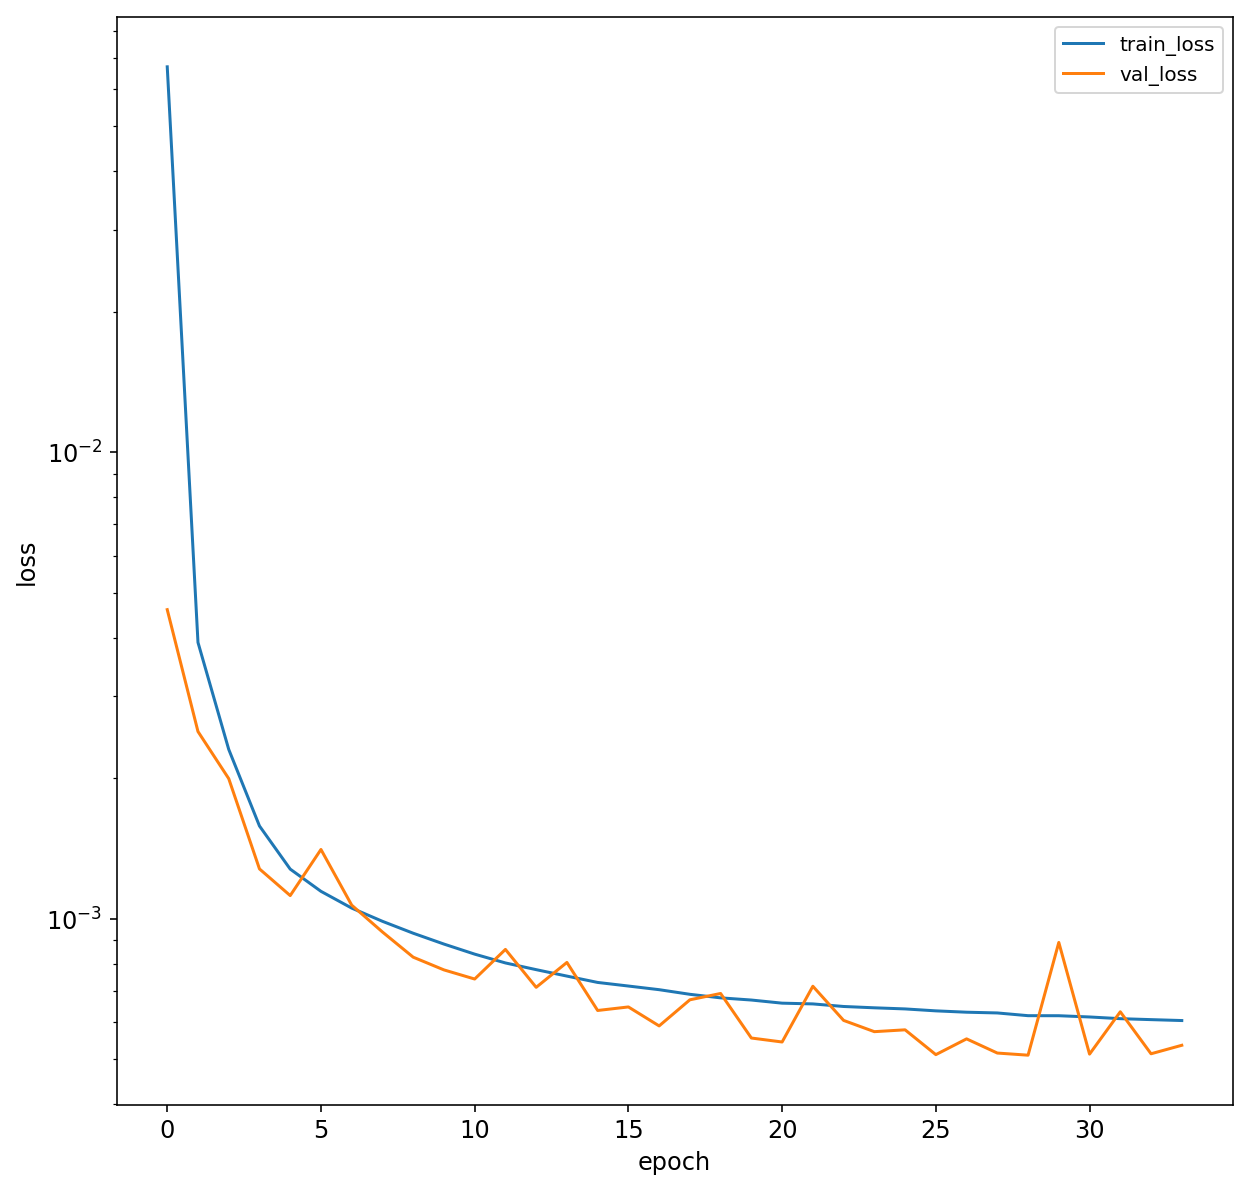

In [135]:
plot_df = pd.DataFrame.from_dict({'train_loss':history.history['loss'], 
                                  'val_loss':history.history['val_loss']})
plot_df.plot(logy=True, figsize=(10,10), fontsize=12)
plt.xlabel('epoch', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.show()

테스트 데이터

In [136]:
look_back_dt = dt.datetime.strptime(test_start_dt, '%Y-%m-%d %H:%M:%S') - dt.timedelta(hours=T-1)
test = energy.copy()[test_start_dt:][['load']]
test.head()

,load
2014-11-01 00:00:00,"2,514.00"
2014-11-01 01:00:00,"2,434.00"
2014-11-01 02:00:00,"2,390.00"
2014-11-01 03:00:00,"2,382.00"
2014-11-01 04:00:00,"2,419.00"


Scale the test data

In [137]:
test['load'] = scaler.transform(test)
test.head()

,load
2014-11-01 00:00:00,0.16
2014-11-01 01:00:00,0.14
2014-11-01 02:00:00,0.13
2014-11-01 03:00:00,0.12
2014-11-01 04:00:00,0.14


Create test set features

In [138]:
test_shifted = test.copy()
test_shifted['y_t+1'] = test_shifted['load'].shift(-1, freq='H')
for t in range(1, T+1):
    test_shifted['load_t-'+str(T-t)] = test_shifted['load'].shift(T-t, freq='H')
test_shifted = test_shifted.dropna(how='any')
y_test = test_shifted['y_t+1'].as_matrix()
X_test = test_shifted[['load_t-'+str(T-t) for t in range(1, T+1)]].as_matrix()

Make predictions on test set

In [139]:
predictions = model.predict(X_test)
predictions

array([[0.22],
       [0.3 ],
       [0.38],
       ...,
       [0.53],
       [0.46],
       [0.42]], dtype=float32)

Compare predictions to actual load

In [140]:
eval_df = pd.DataFrame(predictions, columns=['t+'+str(t) for t in range(1, HORIZON+1)])
eval_df['timestamp'] = test_shifted.index
eval_df = pd.melt(eval_df, id_vars='timestamp', value_name='prediction', var_name='h')
eval_df['actual'] = np.transpose(y_test).ravel()
eval_df[['prediction', 'actual']] = scaler.inverse_transform(eval_df[['prediction', 'actual']])
eval_df.head()

,timestamp,h,prediction,actual
0,2014-11-01 05:00:00,t+1,"2,685.92","2,714.00"
1,2014-11-01 06:00:00,t+1,"2,957.70","2,970.00"
2,2014-11-01 07:00:00,t+1,"3,206.41","3,189.00"
3,2014-11-01 08:00:00,t+1,"3,351.71","3,356.00"
4,2014-11-01 09:00:00,t+1,"3,475.02","3,436.00"


Compute the mean absolute percentage error over all predictions

In [141]:
mape(eval_df['prediction'], eval_df['actual'])

0.015422405472977234

Plot the predictions vs the actuals for the first week of the test set

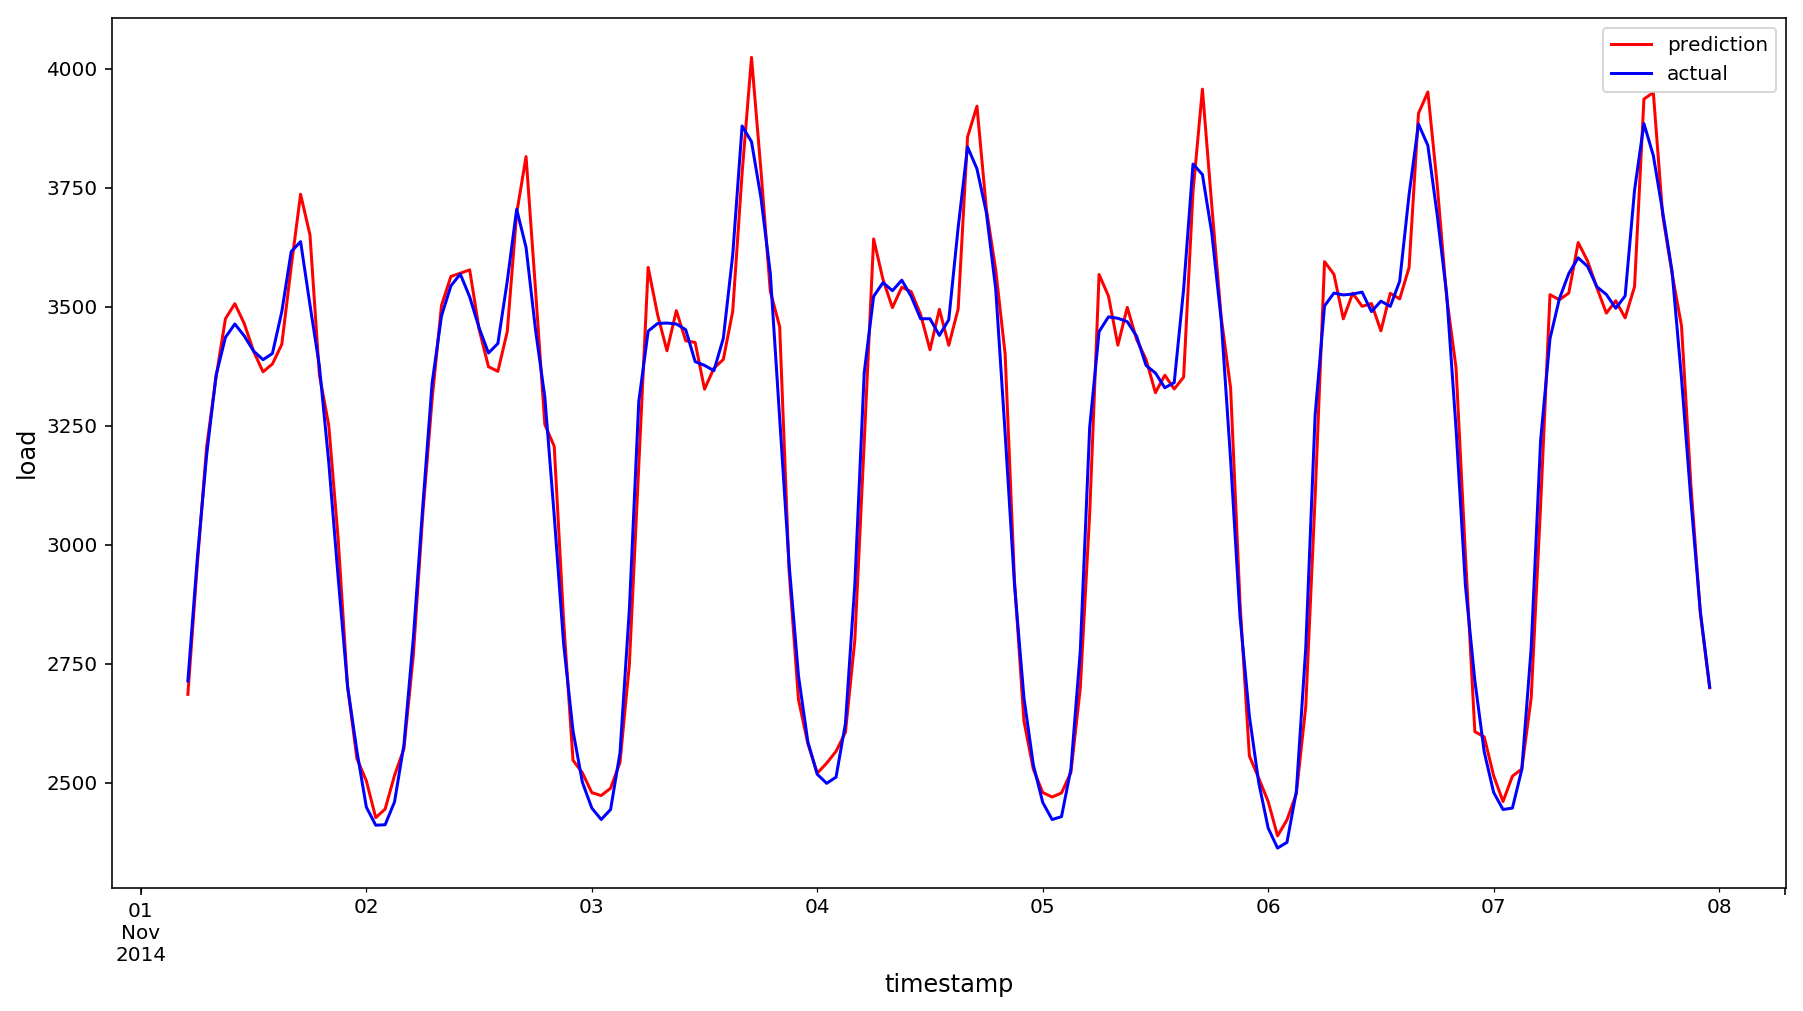

In [142]:
eval_df[eval_df.timestamp<'2014-11-08'].plot(x='timestamp', y=['prediction', 'actual'], style=['r', 'b'], figsize=(15, 8))
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('load', fontsize=12)
plt.show()

In [44]:
# for m in glob('model_*.h5'):
#     os.remove(m)